# 1. Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import json

file_path = '/content/drive/My Drive/Part 3/preprocessed_document_removal_word.json' #To load the json file, Add the shortcut of the Part 3 folder to My Drive in Google Drive.

with open(file_path,'r') as file:
  data = json.load(file)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/Part 3/preprocessed_document_removal_word.json'

# 2. BM25 model

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

In [ ]:
nct_ids = list(data.keys())
documents = list(data.values()) #Pre-processing Done
documents[:5]

['test ability extended release nifedipine procardia xl blood pressure medication permit decrease dose glucocorticoid medication child take treat congenital adrenal hyperplasia cah protocol designed ass acute chronic effect calcium channel antagonist nifedipine axis congenital adrenal hyperplasia multicenter trial composed two phase involve parallel design goal phase examine ability nifedipine placebo decrease adrenocorticotropic hormone acth level well begin ass nifedipine effect goal phase ii evaluate effect nifedipine attenuation acth release nifedipine permit decrease dosage glucocorticoid needed suppress hpa axis decrease would turn reduce deleterious effect glucocorticoid cah',
 'inner city child increased risk lead overburden turn affect cognitive functioning however underlying neuropsychological effect lead overburden effect well delineated part larger effect lead overburden development attention memory larger using approach effect lead overburden effect including potential erp

In [ ]:
# Download rank-bm25 to run BM25 model

!pip install rank-bm25

In [ ]:
from rank_bm25 import BM25Okapi
tokenized_corpus = [doc.split(" ") for doc in documents]

k1 = 11
b = 1
bm25 = BM25Okapi(tokenized_corpus, k1=k1, b=b)


In [ ]:
# Ensure words in the query are in lowercase
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import string
query = 'A 19-year-old male came to clinic with some sexual concern.  He recently engaged in a relationship and is worried about the satisfaction of his girlfriend. He has a &quot;baby face&quot; according to his girlfriend\'s statement and he is not as muscular as his classmates.  On physical examination, there is some pubic hair and poorly developed secondary sexual characteristics. He is unable to detect coffee smell during the examination, but the visual acuity is normal. Ultrasound reveals the testes volume of 1-2 ml. The hormonal evaluation showed serum testosterone level of 65 ng/dL with low levels of GnRH.'
# Tokenize the text into words
tokens = word_tokenize(query)

# Remove punctuation from each word
table = str.maketrans('', '', string.punctuation)
stripped = [w.translate(table) for w in tokens]

# Remove remaining tokens that are not alphabetic (this step also removes the punctuation tokens)
words = [word for word in stripped if word.isalpha()]

# Join words back to text
query = ' '.join(words)

In [ ]:
tokenized_query = word_tokenize(query.lower())
doc_scores = bm25.get_scores(tokenized_query)
bm25_scores_dict = {nct_id: score for nct_id, score in zip(nct_ids, doc_scores)}

In [ ]:
# bm25_scores_dict is your dictionary of scores, where the key is nct_id and the value is the score
# Sort the dictionary by its values (scores) in descending order and take the top 5
top_5_scores = sorted(bm25_scores_dict.items(), key=lambda x: x[1], reverse=True)[:5]

# Print the top 5 scores and their corresponding nct_ids
for nct_id, score in top_5_scores:
    print(f"{nct_id}: {score}")


NCT00044304: 69.42789806312399
NCT00962156: 67.63604533698472
NCT00518544: 64.66253625483716
NCT00493272: 63.06558914344098
NCT00086658: 62.35784888278593


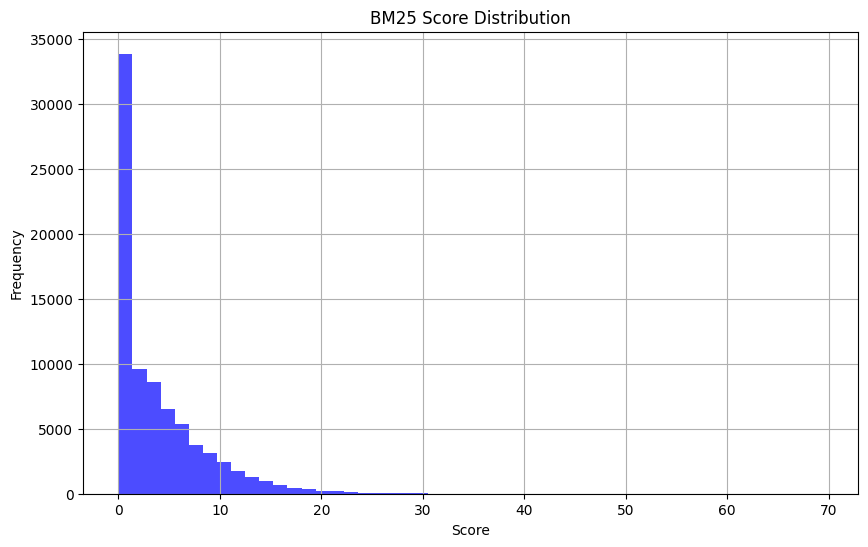

In [ ]:
import matplotlib.pyplot as plt

# Plot BM25 Score Distribution
plt.figure(figsize=(10, 6))
plt.hist(list(bm25_scores_dict.values()), bins=50, color='blue', alpha=0.7)
plt.title('BM25 Score Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 3. LSI Model

In [ ]:
from gensim import corpora, models, similarities
import gensim

# Create a Dictionary object that maps each word to a unique id, using a tokenized version of the corpus.
dictionary = corpora.Dictionary(tokenized_corpus)
# Convert the tokenized corpus into a bag-of-words (BoW) format using the previously created dictionary.
corpus = [dictionary.doc2bow(text) for text in tokenized_corpus]

In [ ]:
# Create a TF-IDF model based on the corpus, which transforms vectors from the BoW model to the TF-IDF model, enhancing the significance of unique words.
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [ ]:
# Create an LSI model using the TF-IDF transformed corpus, specifying the number of topics to be extracted.
lsi_model = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=200)

In [ ]:
# Print the top topics in the LSI model, which are represented as a combination of keywords contributing to each topic.
for topic in lsi_model.print_topics():
    print(topic)

(0, '0.191*"cell" + 0.174*"day" + 0.160*"tumor" + 0.158*"cancer" + 0.140*"chemotherapy" + 0.133*"dose" + 0.130*"iv" + 0.127*"week" + 0.114*"receive" + 0.110*"drug"')
(1, '-0.180*"tumor" + -0.175*"cell" + -0.173*"iv" + -0.166*"chemotherapy" + 0.127*"subject" + -0.121*"stop" + -0.121*"toxicity" + 0.104*"intervention" + -0.101*"cancer" + 0.100*"group"')
(2, '-0.315*"vaccine" + -0.292*"dose" + -0.257*"mg" + -0.231*"safety" + -0.207*"tolerability" + -0.191*"subject" + -0.140*"dos" + -0.122*"pharmacokinetics" + -0.120*"tablet" + -0.119*"single"')
(3, '0.478*"vaccine" + 0.282*"cell" + 0.250*"stem" + 0.187*"donor" + 0.186*"transplant" + 0.167*"immune" + 0.161*"transplantation" + -0.142*"mg" + 0.142*"vaccination" + 0.139*"marrow"')
(4, '0.503*"vaccine" + -0.227*"stem" + -0.198*"mg" + 0.192*"cancer" + -0.165*"transplant" + -0.165*"donor" + -0.155*"day" + -0.155*"transplantation" + 0.151*"breast" + -0.143*"cell"')
(5, '0.456*"insulin" + 0.350*"diabetes" + 0.233*"glucose" + 0.204*"type" + -0.178*"

In [ ]:
# Transform the corpus into the LSI space to prepare for similarity queries.
lsi_corpus = lsi_model[corpus_tfidf]

In [ ]:
# Prepare the query by transforming it into the LSI vector space, following the same steps of BoW, TF-IDF, and then LSI transformation.
query_bow = dictionary.doc2bow(tokenized_query)
query_tfidf = tfidf[query_bow]
query_lsi = lsi_model[query_tfidf]

In [ ]:
# Create a MatrixSimilarity index using the LSI corpus for similarity comparisons. The index enables efficient similarity queries.
index = similarities.MatrixSimilarity(lsi_corpus, num_features=lsi_model.num_topics)
# Calculate the similarity scores of the query against all documents in the LSI corpus.
lsi_scores = index[query_lsi]

In [ ]:
#Create a list of tuples pairing each document ID with its similarity score.
original_nct_ids = list(data.keys())
ranked_docs_with_scores = sorted(zip(original_nct_ids, lsi_scores), key=lambda x: -x[1])

In [ ]:
# Print the top 10 documents sorted by their similarity score to the query.
for doc_id, score in ranked_docs_with_scores[:10]:
    print(f"Document ID: {doc_id}, Score: {score}")

Document ID: NCT00156650, Score: 0.8027017116546631
Document ID: NCT00140153, Score: 0.8013309836387634
Document ID: NCT00494208, Score: 0.7994989156723022
Document ID: NCT00483418, Score: 0.7975277900695801
Document ID: NCT00202163, Score: 0.7945133447647095
Document ID: NCT00555087, Score: 0.7944309711456299
Document ID: NCT00916396, Score: 0.7913656234741211
Document ID: NCT00119483, Score: 0.7887834310531616
Document ID: NCT00522431, Score: 0.7831529378890991
Document ID: NCT00144404, Score: 0.7815320491790771


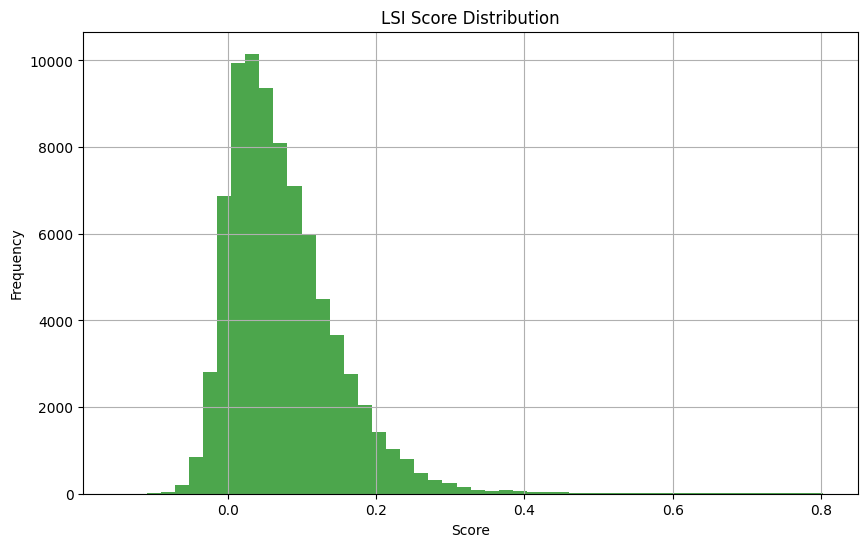

In [ ]:

# Plot LSI Score Distribution
plt.figure(figsize=(10, 6))
plt.hist(lsi_scores, bins=50, color='green', alpha=0.7)
plt.title('LSI Score Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


# 4. Combined score of BM25 score and LSI score

In [ ]:
# Normalize BM25 scores to be between -1 and 1
max_bm25 = max(bm25_scores_dict.values())
min_bm25 = min(bm25_scores_dict.values())

normalized_bm25_scores = {
    nct_id: -1 + 2 * (score - min_bm25) / (max_bm25 - min_bm25)
    if max_bm25 != min_bm25 else 0  # To handle the case where all scores are the same
    for nct_id, score in bm25_scores_dict.items()
}

In [ ]:
specific_nct_id = 'NCT00399165'

# Retrieve the normalized BM25 score for the specified document ID
specific_score = normalized_bm25_scores.get(specific_nct_id, "Score not found")

# Print the normalized BM25 score for the specified document ID
print(f"Normalized BM25 Score for {specific_nct_id}: {specific_score}")

Normalized BM25 Score for NCT00399165: -0.20024850908899006


In [ ]:
top_5_normalized_bm25_scores = sorted(normalized_bm25_scores.items(), key=lambda x: x[1], reverse=True)[:5]

# Print the top 5 normalized BM25 scores and their corresponding document IDs
for nct_id, score in top_5_normalized_bm25_scores:
    print(f"Document ID: {nct_id}, Normalized BM25 Score: {score}")

Document ID: NCT00044304, Normalized BM25 Score: 1.0
Document ID: NCT00962156, Normalized BM25 Score: 0.9483823426568347
Document ID: NCT00518544, Normalized BM25 Score: 0.8627248716660225
Document ID: NCT00493272, Normalized BM25 Score: 0.8167218338110025
Document ID: NCT00086658, Normalized BM25 Score: 0.796334056551447


In [ ]:
max_lsi = max(lsi_scores)
min_lsi = min(lsi_scores)
normalized_lsi_scores = {nct_id: -1 + 2 * (score - min_lsi) / (max_lsi - min_lsi) for nct_id, score in zip(nct_ids, lsi_scores)}

a1, a2 = 0.55, 0.45  # Example adjustment for weighting
combined_scores_dict = {
    nct_id: a1 * normalized_bm25_scores.get(nct_id, 0) + a2 * normalized_lsi_scores.get(nct_id, 0)
    for nct_id in set(normalized_bm25_scores) | set(normalized_lsi_scores)
}

# 5. Rank the documents based on the combined score

In [ ]:
top_5_combined_scores = sorted(combined_scores_dict.items(), key=lambda x: x[1], reverse=True)[:5]

for nct_id, score in top_5_combined_scores:
    print(f"Document ID: {nct_id}, Score: {score}")
    print(f"Document: {data[nct_id][:100]}...")  # Prints first 100 characters of the document for brevity
    print()  # Adds an empty line for better readability


In [ ]:
# Search combined score of specific document
specific_nct_id = 'NCT00398034'

combined_score = combined_scores_dict.get(specific_nct_id, "Score not found")
print(f"Combined Score for {specific_nct_id}: {combined_score}")

Combined Score for NCT00398034: 0.02841096079169833


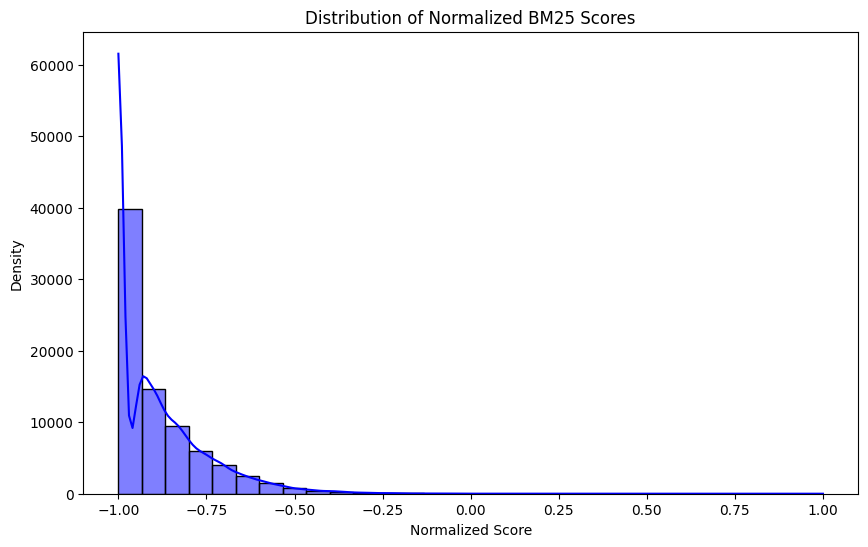

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

bm25_scores_list = list(normalized_bm25_scores.values())

plt.figure(figsize=(10, 6))
sns.histplot(bm25_scores_list, kde=True, color="blue", bins=30)
plt.title("Distribution of Normalized BM25 Scores")
plt.xlabel("Normalized Score")
plt.ylabel("Density")
plt.show()

# 6. Evaluation

In [ ]:
def classify_document(score):
    """
    Classify the document based on its score.

    Args:
    - score (float): The score of the document.

    Returns:
    - int: Classification of the document (2: relevant, 1: excluded, 0: non-relevant).
    """
    if score > 0:
        return 2  # Relevant
    elif -0.5 <= score <= 0:
        return 1  # Excluded
    else:
        return 0  # Non-relevant


In [ ]:
predictions = {nct_id: classify_document(score) for nct_id, score in combined_scores_dict.items()}

In [ ]:
def load_ground_truth():
    ground_truth = {}
    file_path2 = '/content/drive/My Drive/Part 3/relevant_judgement.txt'
    with open(file_path2, 'r') as file:
        for line in file:
            parts = line.strip().split()
            topic_id = int(parts[0])
            doc_id = parts[2]
            truth_label = int(parts[3])

            if topic_id == 1:
                ground_truth[doc_id] = truth_label
    return ground_truth

ground_truth = load_ground_truth()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/Part 3/relevant_judgement.txt'

In [ ]:
def calculate_evaluation_metrics(ground_truth, predictions):
    TP = 0  # True Positives
    FP = 0  # False Positives
    FN = 0  # False Negatives

    # Iterate through predictions for evaluation
    for doc_id, predicted_class in predictions.items():
        actual_class = ground_truth.get(doc_id)

        if predicted_class == 2:  # If predicted as relevant
            if actual_class == 2:
                TP += 1  # Correctly predicted as relevant
            else:
                FP += 1  # Incorrectly predicted as relevant

    # Calculate FN by checking actual relevant documents not predicted as such
    for doc_id, actual_class in ground_truth.items():
        if actual_class == 2 and predictions.get(doc_id, 0) != 2:
            FN += 1  # Relevant documents missed by the model

    # Calculate Precision, Recall, and F1 Score
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score

# Assuming 'ground_truth' and 'predictions' are defined as before
precision, recall, f1_score = calculate_evaluation_metrics(ground_truth, predictions)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")


# 7. Further Work if interested

## You can set the threshold_excluded and threshold relevant to see the evaluation.

### Documents with scores above this threshold but below the "threshold relevant" are often considered "excluded" or "marginally relevant."

### Documents scoring above this threshold are considered "relevant" or "highly relevant."

In [ ]:
def evaluate_model(scores_dict, ground_truth, threshold_excluded=0.25, threshold_relevant=0.75):

    predictions = {}
    for doc_id, score in scores_dict.items():
        # Classify documents based on score thresholds
        if score >= threshold_relevant:
            predictions[doc_id] = 2  # Predicted as relevant
        elif score >= threshold_excluded:
            predictions[doc_id] = 1  # Predicted as excluded (or marginally relevant)
        else:
            predictions[doc_id] = 0  # Predicted as non-relevant

    TP = 0  # True Positives
    FP = 0  # False Positives
    FN = 0  # False Negatives

    for doc_id, predicted_class in predictions.items():
        actual_class = ground_truth.get(doc_id, 0)  # Default to 0 if doc_id not in ground_truth
        if predicted_class == 2:  # Relevant
            if actual_class == 2:
                TP += 1
            else:
                FP += 1

    for doc_id, actual_class in ground_truth.items():
        if actual_class == 2 and predictions.get(doc_id, 0) != 2:
            FN += 1

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return {
        "precision": precision,
        "recall": recall,
        "F1": f1_score
    }


In [ ]:

bm25_results = evaluate_model(normalized_bm25_scores, ground_truth, -0.5, )
lsi_results = evaluate_model(normalized_lsi_scores, ground_truth, -0.25, 0.8)

print("BM25 Results:", bm25_results)
print("LSI Results:", lsi_results)